# Homework 2



In [ ]:
# Import all necessary libraries
import os
import re
import itertools
import collections
from textblob import TextBlob
from functools import partial
import tweepy as tw
import json 
import pandas as pd
import scipy.stats
import numpy as np
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.corpus import stopwords

# Extracting Twitter Data

In [ ]:
# Authorization for tweepy
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Define the search term and the date_since date as variables
search_words = "#democrats"
date_since = "2020-07-10"

# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(1000)


In [ ]:
# Convert to JSON
searched_tweets = [status._json for status in tweets]
json_strings = [json.dumps(json_obj) for json_obj in searched_tweets]  

# Write to file
with open("democratsnew.json", "w", encoding='utf8') as f: 
    f.write('[')
    for i,x in enumerate(json_strings):
        f.write(x)
        if i != len(json_strings) - 1:
            f.write(",")
    f.write(']')

# Etc for other hashtags

# Generating the Dataframe

In [ ]:
# Load in the data into these six variables

with open('bidenharrisnew.json', 'r') as tweetfile:
  bidenharris = json.loads(tweetfile.read())
with open('bidennew.json', 'r') as tweetfile:
  biden = json.loads(tweetfile.read())
with open('democratsnew.json', 'r') as tweetfile:
  democrats = json.loads(tweetfile.read())
with open('maga2020new.json', 'r') as tweetfile:
  maga2020 = json.loads(tweetfile.read())
with open('republicansnew.json', 'r') as tweetfile:
  republicans = json.loads(tweetfile.read())
with open('trumpnew.json', 'r') as tweetfile:
  trump = json.loads(tweetfile.read())

In [ ]:
# Very few people enter their user location as United States, and most people leave it blank.
# (219 out of 5915 tweets)
# Leaving it blank doesn't necessarily mean they don't live in the US.
# Because this won't be very useful, we'll drop it.
has_us_loc = 0
has_empty_loc = 0
for tweet in bidenharris:
  if tweet['user']['location'] == 'United States':
    has_us_loc += 1
  if tweet['user']['location'] == '':
    has_empty_loc += 1
for tweet in biden:
  if tweet['user']['location'] == 'United States':
    has_us_loc += 1
  if tweet['user']['location'] == '':
    has_empty_loc += 1
for tweet in democrats:
  if tweet['user']['location'] == 'United States':
    has_us_loc += 1
  if tweet['user']['location'] == '':
    has_empty_loc += 1
for tweet in maga2020:
  if tweet['user']['location'] == 'United States':
    has_us_loc += 1
  if tweet['user']['location'] == '':
    has_empty_loc += 1
for tweet in republicans:
  if tweet['user']['location'] == 'United States':
    has_us_loc += 1
  if tweet['user']['location'] == '':
    has_empty_loc += 1
for tweet in trump:
  if tweet['user']['location'] == 'United States':
    has_us_loc += 1
  if tweet['user']['location'] == '':
    has_empty_loc += 1

print('US:', has_us_loc)
print('No location:', has_empty_loc)

US: 219
No location: 2045


In [ ]:
# Total tweets
len(bidenharris) + len(biden) + len(democrats) + len(maga2020) + len(trump) + len(republicans)

5915

In [ ]:
# Function to help with filtering. 
# Removes tweets with no valid hashtags or both republican and democrat hashtags
# Also removes tweets that start with 'RT @', because these are retweets even though they are not listed as such...
def has_valid_hashtag(tweet, party):
  if 'RT @' in tweet['full_text']:
    return False
  dem = ['bidenharris', 'biden', 'democrats']
  rep = ['maga2020', 'trump', 'republicans']
  is_dem = False
  is_rep = False
  for tag in tweet['entities']['hashtags']:
    if tag['text'].lower() in dem:
      is_dem = True
    if tag['text'].lower() in rep:
      is_rep = True
  if is_dem and is_rep:
    return False
  if party == "dem" and is_dem:
    return True
  if party == "rep" and is_rep:
    return True
  return False

In [ ]:
# Filter the tweets
filtered_biden = list(filter(partial(has_valid_hashtag, party="dem"), biden))
filtered_bidenharris = list(filter(partial(has_valid_hashtag, party="dem"), bidenharris))
filtered_democrats = list(filter(partial(has_valid_hashtag, party="dem"), democrats))
filtered_maga2020 = list(filter(partial(has_valid_hashtag, party="rep"), maga2020))
filtered_trump = list(filter(partial(has_valid_hashtag, party="rep"), trump))
filtered_republicans = list(filter(partial(has_valid_hashtag, party="rep"), republicans))

In [ ]:
# What's the total remaining data after filtering?
len(filtered_democrats) + len(filtered_bidenharris) + len(filtered_biden) + len(filtered_maga2020) + len(filtered_trump) + len(filtered_republicans)

1737

In [ ]:
# Information to extract from the tweets:
# Date and time (reformatted)
# Text
# Favorite count
# Retweet count
# Follower count (of user who posted the tweet)

# Combine the data into lists for each variable we want to keep

# Use extend to put together the six lists
created = [tweet['created_at'] for tweet in filtered_bidenharris]
created.extend([tweet['created_at'] for tweet in filtered_biden])
created.extend([tweet['created_at'] for tweet in filtered_democrats])
created.extend([tweet['created_at'] for tweet in filtered_maga2020])
created.extend([tweet['created_at'] for tweet in filtered_trump])
created.extend([tweet['created_at'] for tweet in filtered_republicans])

text = [tweet['full_text'] for tweet in filtered_bidenharris]
text.extend([tweet['full_text'] for tweet in filtered_biden])
text.extend([tweet['full_text'] for tweet in filtered_democrats])
text.extend([tweet['full_text'] for tweet in filtered_maga2020])
text.extend([tweet['full_text'] for tweet in filtered_trump])
text.extend([tweet['full_text'] for tweet in filtered_republicans])

favorites = [tweet['favorite_count'] for tweet in filtered_bidenharris]
favorites.extend([tweet['favorite_count'] for tweet in filtered_biden])
favorites.extend([tweet['favorite_count'] for tweet in filtered_democrats])
favorites.extend([tweet['favorite_count'] for tweet in filtered_maga2020])
favorites.extend([tweet['favorite_count'] for tweet in filtered_trump])
favorites.extend([tweet['favorite_count'] for tweet in filtered_republicans])

retweets = [tweet['retweet_count'] for tweet in filtered_bidenharris]
retweets.extend([tweet['retweet_count'] for tweet in filtered_biden])
retweets.extend([tweet['retweet_count'] for tweet in filtered_democrats])
retweets.extend([tweet['retweet_count'] for tweet in filtered_maga2020])
retweets.extend([tweet['retweet_count'] for tweet in filtered_trump])
retweets.extend([tweet['retweet_count'] for tweet in filtered_republicans])

followers = [tweet['user']['followers_count'] for tweet in filtered_bidenharris]
followers.extend([tweet['user']['followers_count'] for tweet in filtered_biden])
followers.extend([tweet['user']['followers_count'] for tweet in filtered_democrats])
followers.extend([tweet['user']['followers_count'] for tweet in filtered_maga2020])
followers.extend([tweet['user']['followers_count'] for tweet in filtered_trump])
followers.extend([tweet['user']['followers_count'] for tweet in filtered_republicans])

party = ['Democrat' for tweet in filtered_bidenharris]
party.extend(['Democrat' for tweet in filtered_biden])
party.extend(['Democrat' for tweet in filtered_democrats])
party.extend(['Republican' for tweet in filtered_maga2020])
party.extend(['Republican' for tweet in filtered_trump])
party.extend(['Republican' for tweet in filtered_republicans])

In [ ]:
# Merge the lists into one data frame. This is what we will analyze. 
df = pd.DataFrame({'created': created, 'text': text, 'favorites': favorites, 'retweets': retweets, 'followers': followers, 'party': party})

# Convert 'created' to datetime object
df['created'] = pd.to_datetime(df['created'])

In [ ]:
df.head(5)

,created,text,favorites,retweets,followers,party
0,2020-08-16 23:59:50+00:00,I think it’s time for me to get some new Birke...,32,3,3418,Democrat
1,2020-08-16 23:59:44+00:00,Jump on board #BidenHarris we have room on the...,0,0,5474,Democrat
2,2020-08-16 23:59:29+00:00,@SethAbramson #StopExcusingTrumpFail it's kill...,0,0,4992,Democrat
3,2020-08-16 23:59:01+00:00,Does anyone else think that this is the most i...,0,0,24,Democrat
4,2020-08-16 23:58:23+00:00,The House Of The Drinker https://t.co/PvbbENZE...,0,0,567,Democrat


In [ ]:
# What's the range of dates here?
print(df['created'].min())
print(df['created'].max())
# Basically 12 hours of data

2020-08-16 11:57:35+00:00
2020-08-16 23:59:54+00:00


In [ ]:
# Write to CSV so we don't have to do all this pre-processing again
df.to_csv('tweet_dataframe.csv', index=False)

# Sentiment Analysis

In [ ]:
# Textblob tweet sentiment analysis functions
def clean_tweet(tweet): 
  ''' 
  Utility function to clean tweet text by removing links, special characters 
  using simple regex statements. 
  '''
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def get_tweet_sentiment_value(tweet):
  analysis = TextBlob(clean_tweet(tweet))
  return analysis.sentiment.polarity

def get_tweet_sentiment_category(tweet): 
  ''' 
  Utility function to classify sentiment of passed tweet 
  using textblob's sentiment method 
  '''
  # create TextBlob object of passed tweet text 
  analysis = TextBlob(clean_tweet(tweet)) 
  # set sentiment 
  if analysis.sentiment.polarity > 0: 
    return 'positive'
  elif analysis.sentiment.polarity == 0: 
    return 'neutral'
  else: 
    return 'negative'

In [ ]:
# Compute the sentiment score and category and add it to the dataframe
df['sentiment_value'] = df['text'].apply(get_tweet_sentiment_value)
df['sentiment_category'] = df['text'].apply(get_tweet_sentiment_category)

In [ ]:
# Counts of each category for the sentiment, overall
pd.value_counts(df['sentiment_category'])

positive    691
neutral     585
negative    461
Name: sentiment_category, dtype: int64

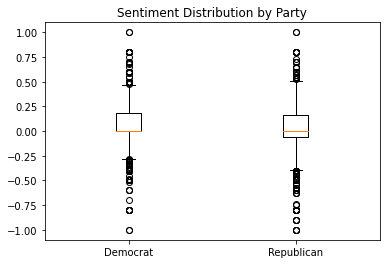

In [ ]:
# Make a boxplot for sentiment distribution by party
dem_ind = (df['party'] == 'Democrat')
rep_ind = (df['party'] == 'Republican')
plt.boxplot([df['sentiment_value'][dem_ind], df['sentiment_value'][rep_ind]])
plt.xticks(ticks=[1,2], labels=['Democrat', 'Republican'])
plt.title("Sentiment Distribution by Party")
plt.show()

In [ ]:
# Do a two-sample t-test to see if the sentiment scores differ by party
scipy.stats.ttest_ind(df['sentiment_value'][dem_ind], df['sentiment_value'][rep_ind])

Ttest_indResult(statistic=2.1319402263657397, pvalue=0.03315188344090818)

In [ ]:
# Which party has a higher sentiment?
print('Dem mean:', df['sentiment_value'][dem_ind].mean())
print('Rep mean:', df['sentiment_value'][rep_ind].mean())
# Democrats, barely

Dem mean: 0.060167058960249375
Rep mean: 0.03166932771252298


In [ ]:
# Aggregate counts of sentiment category by party
dem_sent_counts = df['sentiment_category'][dem_ind].value_counts()
rep_sent_counts = df['sentiment_category'][rep_ind].value_counts()
positive_counts = [dem_sent_counts['positive'], rep_sent_counts['positive']]
neutral_counts = [dem_sent_counts['neutral'], rep_sent_counts['neutral']]
negative_counts = [dem_sent_counts['negative'], rep_sent_counts['negative']]

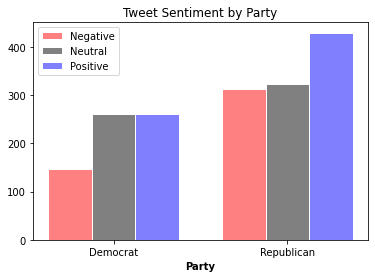

In [ ]:
# Create a barplot of the sentiment category counts by party
barWidth = 0.25
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, negative_counts, color='#ff8080', width=barWidth, edgecolor='white', label='Negative')
plt.bar(r2, neutral_counts, color='#808080', width=barWidth, edgecolor='white', label='Neutral')
plt.bar(r3, positive_counts, color='#8080ff', width=barWidth, edgecolor='white', label='Positive')

plt.xlabel('Party', fontweight='bold')
plt.xticks([r + barWidth for r in range(2)], ['Democrat', 'Republican'])

plt.title('Tweet Sentiment by Party')
plt.legend()
plt.show()

# WordClouds

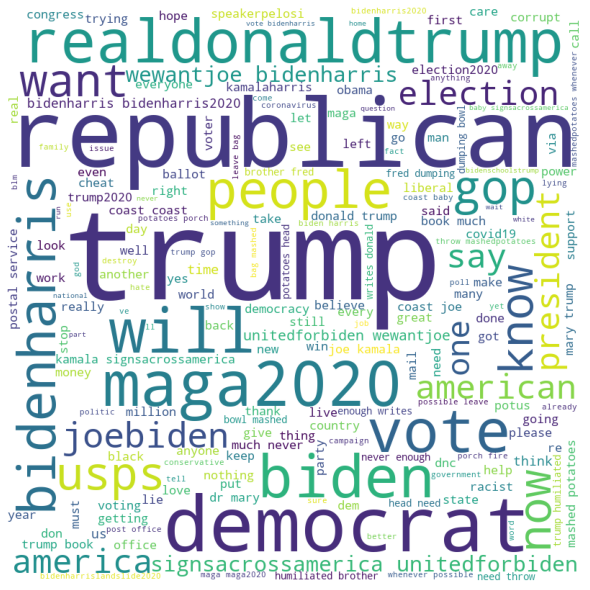

In [ ]:
# Python program to generate WordCloud 

# Reads 'PARTY.csv' file 
# df = pd.read_csv(r"C:/Users/KnudseQ/Desktop/tweet_dataframe.csv", encoding ="latin-1") 
df = pd.read_csv("/content/tweet_dataframe.csv")

comment_words = '' 
custom_stopwords = ["https", "co", "amp"]
stopwords = set(STOPWORDS).union(custom_stopwords) 

# iterate through the csv file 
for val in df.text: 
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [ ]:
df = pd.read_csv("/content/candidatetweets_dataframe.csv")
trump = df.loc[df['name'] == "Donald J. Trump"]
biden = df.loc[df['name'] == "Joe Biden"]

Trump Tweets 

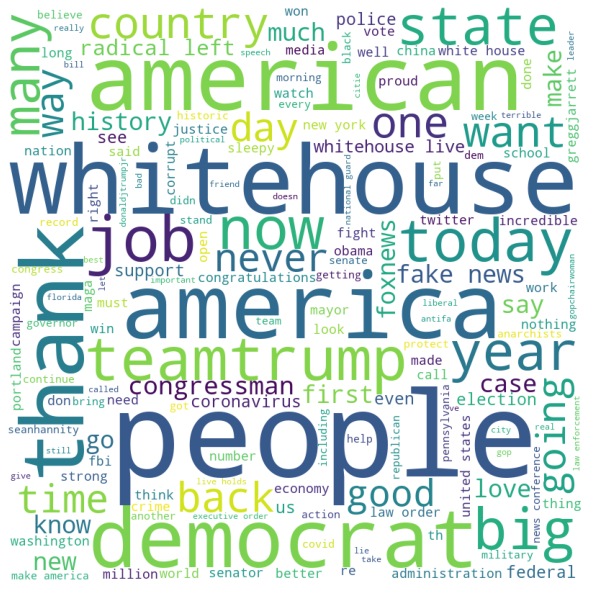

In [ ]:
comment_words = '' 
custom_stopwords = ["https", "co", "amp","will","rt","realdonaldtrump","president","joe biden","biden","great","joe","trump"]
stopwords = set(STOPWORDS).union(custom_stopwords) 

# iterate through the csv file 
for val in trump.text: 
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

Biden Tweets

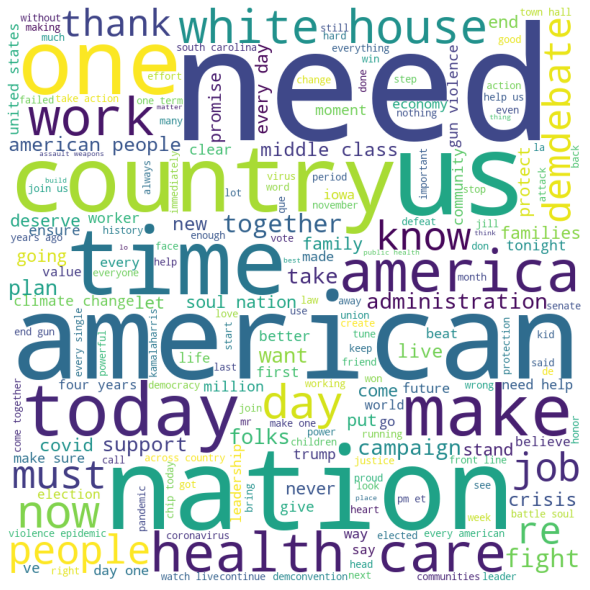

In [ ]:
comment_words = '' 
custom_stopwords = ["https", "co", "amp","will","rt","realdonaldtrump","ll","president","joe biden","biden","great","joe","trump","donald"]
stopwords = set(STOPWORDS).union(custom_stopwords) 

# iterate through the csv file 
for val in biden.text: 
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

#Extracting Candidate Tweets


In [ ]:
#### the code in his block was used to scrape tweets
##twitter api stuff! **** 
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Collect tweets for biden ******** API keys removed from code
tweets = tw.Cursor(api.user_timeline,
                   screenname ='JoeBiden', 
                   tweet_mode = "extended", 
                   include_rts=False,).items()

##json
searched_tweets = [status._json for status in tweets]
json_strings = [json.dumps(json_obj) for json_obj in searched_tweets]  

## save biden tweets to json file
with open("bidentweets.json", "w", encoding='utf8') as f: 
    f.write('[')
    for i,x in enumerate(json_strings):
        f.write(x)
        if i != len(json_strings) - 1:
            f.write(",")
        
    f.write(']')


## extract tweets for donald trump ******** API keys removed from code
def get_all_tweets(realDonaldTrump):
#Twitter only allows access to a users most recent 3240 tweets with this method
#authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    #initialize a list to hold all the tweepy Tweets
    alltweets = []
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = realDonaldTrump,count=200)
    #save most recent tweets
    alltweets.extend(new_tweets)
    #save the id of the oldest tweet less one
    oldestIndex = len(alltweets) - 1
    print (oldestIndex)
    oldest = alltweets[oldestIndex].id - 1
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print ("getting tweets before %s" %(oldest))
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = realDonaldTrump,count=200,max_id=oldest)
        #save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        print ("...%s tweets downloaded so far" % (len(alltweets)))
    #transform the tweepy tweets into a 2D array that will populate the csv
    searched_tweets = [status._json for status in alltweets]
    json_strings = [json.dumps(json_obj) for json_obj in searched_tweets]  
    with open("trumptweets8_21.json", "w", encoding='utf8') as f: 
        f.write('[')
        for i,x in enumerate(json_strings):
            f.write(x)
            if i != len(json_strings) - 1:
                f.write(",")
        
        f.write(']')

get_all_tweets("realDonaldTrump")

In [ ]:
## open our json files for candidate tweets
with open('bidentweets.json', 'r') as tweetfile:
  btweets = json.loads(tweetfile.read())
with open('trumptweets.json', 'r') as tweetfile:
  ttweets = json.loads(tweetfile.read())

# Filter (remove tweets with zero favorites, because most were retweets), showing number of tweets before and after
print(len(btweets), len(ttweets))
btweets = list(filter(lambda x: x['favorite_count'] != 0, btweets))
ttweets = list(filter(lambda x: x['favorite_count'] != 0, ttweets))
print(len(btweets), len(ttweets))

3000 11486
3000 5518


In [ ]:
# Information to extract from the tweets:
# Date and time (reformatted)\
# Name of Candidate
# Text
# Favorite count
# Retweet count

# Combine the data into lists for each variable we want to keep

# Use extend to put together the six lists
created = [tweet['created_at'] for tweet in btweets]
created.extend([tweet['created_at'] for tweet in ttweets])

name = ['Joe Biden' for tweet in btweets]
name.extend(['Donald J. Trump' for tweet in ttweets])

text = [tweet[ 'full_text'] for tweet in btweets]
text.extend([tweet['text'] for tweet in ttweets])

favorites = [tweet['favorite_count'] for tweet in btweets]
favorites.extend([tweet['favorite_count'] for tweet in ttweets])

retweets = [tweet['retweet_count'] for tweet in btweets]
retweets.extend([tweet['retweet_count'] for tweet in ttweets])

# Merge the lists into one data frame. This is what we will analyze. 
df1 = pd.DataFrame({'created': created, 'name': name,'text': text, 'favorites': favorites, 'retweets': retweets})

# Convert 'created' to datetime object
df1['created'] = pd.to_datetime(df1['created'])

# What's the range of dates here?
print(df1['created'].min())
print(df1['created'].max())

# Write to CSV so we don't have to do all this pre-pre-processing again
df1.to_csv('candidatetweets_dataframe.csv', index=False)

2019-08-28 01:41:00+00:00
2020-08-25 04:37:54+00:00


# Favorites and Retweets

In [ ]:
## read in csv for tweets 
ctweets = pd.read_csv("candidatetweets_dataframe.csv", header=0, parse_dates=True, squeeze=True)

#find the avg favorites by candidate
print('Average favorites for Trump: {:.2f}'.format(ctweets.loc[ctweets['name'] == 'Donald J. Trump', 'favorites'].mean()))
print('Average favorites for Biden: {:.2f}'.format(ctweets.loc[ctweets['name'] == 'Joe Biden', 'favorites'].mean()))

## find the avg retweets by candidate
print('Average retweets for Trump: {:.2f}'.format(ctweets.loc[ctweets['name'] == 'Donald J. Trump', 'retweets'].mean()))
print('Average retweets for Biden: {:.2f}'.format(ctweets.loc[ctweets['name'] == 'Joe Biden', 'retweets'].mean()))

Average favorites for Trump: 96453.07
Average favorites for Biden: 33269.89
Average retweets for Trump: 22296.34
Average retweets for Biden: 6546.78


Biden's oldest tweet in this df is from: 2019-08-28 01:41:00+00:00
Biden's latest tweet in this df is from: 2020-08-20 03:30:00+00:00
Trump's oldest tweet in this df is from: 2019-08-28 11:22:27+00:00
Trump's latest tweet in this df is from: 2020-08-25 04:37:54+00:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

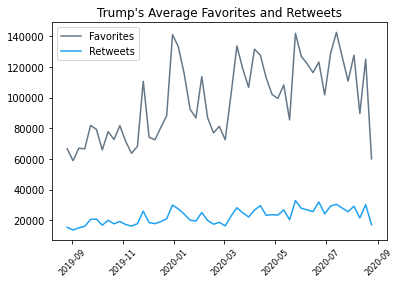

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


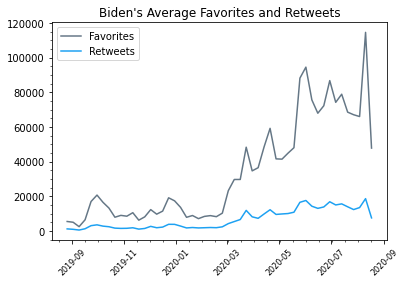

In [ ]:
# Plot Favorites and Retweets over Time

## determine a range of dates for oldest and latest tweets for each candidate
biden_oldest_tweet = (ctweets.loc[ctweets['name'] == 'Joe Biden', 'created'].min())
biden_latest_tweet = (ctweets.loc[ctweets['name'] == 'Joe Biden', 'created'].max())
print("Biden's oldest tweet in this df is from:", biden_oldest_tweet)
print("Biden's latest tweet in this df is from:", biden_latest_tweet)

trump_oldest_tweet = (ctweets.loc[ctweets['name'] == 'Donald J. Trump', 'created'].min())
trump_latest_tweet = (ctweets.loc[ctweets['name'] == 'Donald J. Trump', 'created'].max())
print("Trump's oldest tweet in this df is from:",trump_oldest_tweet)
print("Trump's latest tweet in this df is from:", trump_latest_tweet)

## subset tweets for each candidate
trump = ctweets[ctweets['name'] == "Donald J. Trump"]
biden = ctweets[ctweets['name'] == "Joe Biden"]
trump["created"] = pd.to_datetime(trump["created"])
biden["created"] = pd.to_datetime(biden["created"])
trump.dtypes

## convert date to first day of week group so we can then group rt and favs by week 
trump['first_day'] = trump['created'] - trump['created'].dt.weekday * np.timedelta64(1, 'D')
trump['first_day'] = pd.to_datetime(trump['first_day']).dt.date

## group trump tweets by week
trumpgrouped = trump.groupby('first_day').mean()

## plot trumps favorites and retweets grouped by week
trumpplot, = plt.plot(trumpgrouped.index, trumpgrouped['favorites'], '#657786')
trumpplot.set_label('Trump')
trumpplot, = plt.plot(trumpgrouped.index, trumpgrouped['retweets'], '#1DA1F2')
trumpplot.set_label('Trump')
plt.gca().legend(('Favorites','Retweets'))
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
#plt.minorticks_on()
#plt.tick_params(axis='x',which='minor',bottom=True)
plt.title("Trump's Average Favorites and Retweets")
plt.show()

## create a new column with first day of the week 
biden['first_day'] = biden['created'] - biden['created'].dt.weekday * np.timedelta64(1, 'D')
biden['first_day'] = pd.to_datetime(biden['first_day']).dt.date
## group by first day of the week 
bidengrouped= biden.groupby('first_day').mean()

## plot bidens favorites and retweets grouped by week
bplot, = plt.plot(bidengrouped.index, bidengrouped['favorites'], '#657786')
bplot.set_label('Biden')
bplot, = plt.plot(bidengrouped.index, bidengrouped['retweets'], '#1DA1F2')
bplot.set_label('Biden')

plt.gca().legend(('Favorites','Retweets'))
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.minorticks_on()
plt.title("Biden's Average Favorites and Retweets")
plt.show()

#Bar chart of top words

In [ ]:
df = pd.read_csv("/content/candidatetweets_dataframe.csv")

,created,name,text,favorites,retweets,followers,party
0,2020-08-21 15:49:30+00:00,Donald J. Trump,RT @WhiteHouse: LIVE: POTUS remarks at the 202...,0,6032,85453669,Republican
1,2020-08-21 15:31:35+00:00,Donald J. Trump,https://t.co/4V7nu5ySxv,49284,17124,85453669,Republican
2,2020-08-21 13:28:51+00:00,Donald J. Trump,https://t.co/4xmC4xKWjm,94760,30921,85453669,Republican
3,2020-08-21 03:10:23+00:00,Donald J. Trump,RT @realDonaldTrump: THANK YOU! #MAGA https://...,0,33875,85453669,Republican
4,2020-08-21 03:09:55+00:00,Donald J. Trump,"In 47 years, Joe did none of the things of whi...",263879,55886,85453669,Republican
...,...,...,...,...,...,...,...
5995,2019-08-28 22:51:19+00:00,Joe Biden,He honorably served our nation in uniform and ...,1069,177,8649005,Democrat
5996,2019-08-28 22:51:19+00:00,Joe Biden,.@McCreadyForNC is precisely the kind of leade...,1611,335,8649005,Democrat
5997,2019-08-28 20:36:00+00:00,Joe Biden,Thank you to everyone who came out to our town...,1368,263,8649005,Democrat
5998,2019-08-28 19:32:34+00:00,Joe Biden,What kind of leader taunts their own people as...,32627,6876,8649005,Democrat


In [ ]:
comment_words = '' 
custom_stopwords = ["https", "co", "amp","will","rt","realdonaldtrump","president","joe biden","biden","great","joe","trump"]
stopwords = set(STOPWORDS).union(custom_stopwords) 

# iterate through the csv file 
for val in df.text: 
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

In [ ]:
data = df
top_N = 20
word_dist = nltk.FreqDist(data['text'])
print('All frequencies')
print('='*60)
rslt=pd.DataFrame(word_dist.most_common(top_N),columns=['Word','Frequency'])

print(rslt)
print ('='*60)

All frequencies
                                                 Word  Frequency
0                                    LAW &amp; ORDER!         12
1                           MAKE AMERICA GREAT AGAIN!         10
2      RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN!          8
3               RT @realDonaldTrump: LAW &amp; ORDER!          6
4   96% Approval Rating in the Republican Party. T...          4
5                            PRESIDENTIAL HARASSMENT!          2
6   RT @realDonaldTrump: 96% Approval Rating in th...          2
7   The American people deserve to know what Donal...          2
8   RT @WhiteHouse: LIVE: POTUS remarks at the 202...          1
9                             https://t.co/4V7nu5ySxv          1
10                            https://t.co/4xmC4xKWjm          1
11  RT @realDonaldTrump: THANK YOU! #MAGA https://...          1
12  In 47 years, Joe did none of the things of whi...          1
13  RT @realDonaldTrump: THANK YOU PENNSYLVANIA! #...          1
14       

In [ ]:
import re
def alpha_filter(w): 
  pattern = re.compile('^[^a-z]+$') 
  if (pattern.match(w)): 
    return True 
  else:
    return False

In [ ]:
all_tweets=df["text"]
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['RT WhiteHouse LIVE POTUS remarks at the 2020 Council for National Policy Meeting',
 '',
 '',
 'RT realDonaldTrump THANK YOU MAGA',
 'In 47 years Joe did none of the things of which he now speaks He will never change just words']

In [ ]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())


In [ ]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['RT WhiteHouse LIVE POTUS remarks at the 2020 Council for National Policy Meeting',
 '',
 '',
 'RT realDonaldTrump THANK YOU MAGA',
 'In 47 years Joe did none of the things of which he now speaks He will never change just words']

In [ ]:
# Make all elements in the list lowercase
lower_case = [word.lower() for word in all_tweets_no_urls]

# Get all elements in the list
lower_case[:5]

['rt whitehouse live potus remarks at the 2020 council for national policy meeting',
 '',
 '',
 'rt realdonaldtrump thank you maga',
 'in 47 years joe did none of the things of which he now speaks he will never change just words']

In [ ]:
# Split the words from one tweet into unique elements
lower_case[0].split()

['rt',
 'whitehouse',
 'live',
 'potus',
 'remarks',
 'at',
 'the',
 '2020',
 'council',
 'for',
 'national',
 'policy',
 'meeting']

In [ ]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[:2]

[['rt',
  'whitehouse',
  'live',
  'potus',
  'remarks',
  'at',
  'the',
  '2020',
  'council',
  'for',
  'national',
  'policy',
  'meeting'],
 []]

In [ ]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('the', 6346),
 ('to', 5115),
 ('and', 3982),
 ('of', 2807),
 ('a', 2694),
 ('in', 2314),
 ('we', 2028),
 ('is', 1803),
 ('for', 1696),
 ('rt', 1617),
 ('our', 1565),
 ('this', 1334),
 ('i', 1241),
 ('on', 1226),
 ('president', 1105)]

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['rt',
 'whitehouse',
 'live',
 'potus',
 'remarks',
 '2020',
 'council',
 'national',
 'policy',
 'meeting']

In [ ]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('rt', 1617),
 ('president', 1105),
 ('trump', 966),
 ('donald', 579),
 ('realdonaldtrump', 471),
 ('need', 465),
 ('people', 432),
 ('us', 429),
 ('american', 420),
 ('one', 397),
 ('get', 370),
 ('country', 362),
 ('im', 362),
 ('make', 345),
 ('nation', 331)]

In [ ]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,the,6346
1,to,5115
2,and,3982
3,of,2807
4,a,2694


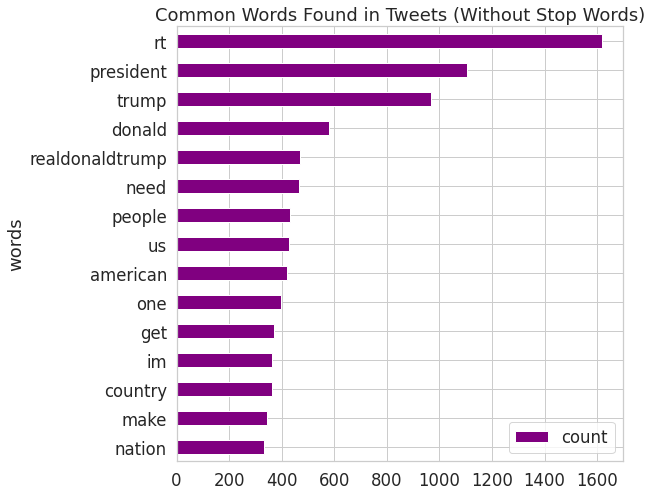

In [ ]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

In [ ]:
collection_words = ['rt','im','get']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

In [ ]:
# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))

# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

[('president', 1105),
 ('trump', 966),
 ('donald', 579),
 ('realdonaldtrump', 471),
 ('need', 465),
 ('people', 432),
 ('us', 429),
 ('american', 420),
 ('one', 397),
 ('country', 362),
 ('make', 345),
 ('nation', 331),
 ('every', 326),
 ('time', 299),
 ('day', 296)]

In [ ]:
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])
clean_tweets_ncw.head()

,words,count
0,president,1105
1,trump,966
2,donald,579
3,realdonaldtrump,471
4,need,465


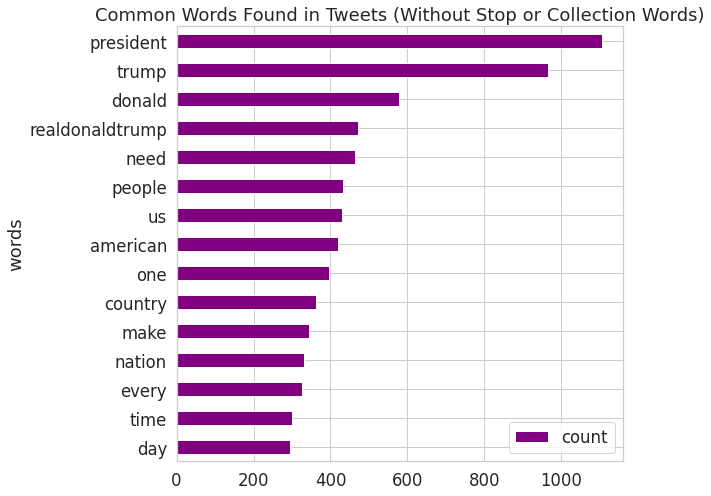

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()